In [43]:
# ========================================
# CELL 1: Import Libraries and Load Data
# ========================================

import os
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import warnings
warnings.filterwarnings("ignore")

# --- ensure train_df exists (run this BEFORE any cells that reference train_df) ---
from pathlib import Path
import pandas as pd
import os

# candidate paths (works both on Kaggle and locally)
candidates = [
    Path("/kaggle/input/grid-prediction/training.csv"),                          # Kaggle
    Path("kaggle") / "input" / "grid-prediction" / "training.csv",              # project-relative
    Path.cwd() / "kaggle" / "input" / "grid-prediction" / "training.csv",       # explicit cwd join
]

train_path = None
for p in candidates:
    if p.exists():
        train_path = p
        break

if train_path is None:
    raise FileNotFoundError(
        "training.csv not found. Put it in ./kaggle/input/grid-prediction/ or update path."
    )

print("Loading training file:", train_path)
train_df = pd.read_csv(train_path)   # <-- this creates train_df used later
print("Loaded train_df: rows =", train_df.shape[0], "cols =", train_df.shape[1])
display(train_df.head())


Loading training file: kaggle\input\grid-prediction\training.csv
Loaded train_df: rows = 267324 cols = 11


,Date,Power Station,Monitored Cap.(MW),Total Cap. Under Maintenace (MW),Planned Maintanence (MW),Forced Maintanence(MW),Other Reasons (MW),Programme (MW),Actual (MW),Excess(+) / Shortfall (-) (MW),Deviation (MW)
0,01-09-2017,Tripura,169.5,85.5,0.0,0.0,85.5,1.50,1.79,0.29,19.33
1,01-09-2017,BEPL,450.0,450.0,0.0,450.0,0.0,0.00,0.00,0.00,0.00
2,01-09-2017,NHPC,862.0,33.0,33.0,0.0,0.0,19.84,19.98,0.14,0.71
3,01-09-2017,ONGC,726.6,363.3,0.0,0.0,363.3,14.35,8.17,-6.18,-43.07
4,01-09-2017,BRBCL,500.0,0.0,0.0,0.0,0.0,10.53,11.35,0.82,7.79


📈 Starting ENHANCED visual data analysis...

                              1️⃣ TARGET ANALYSIS


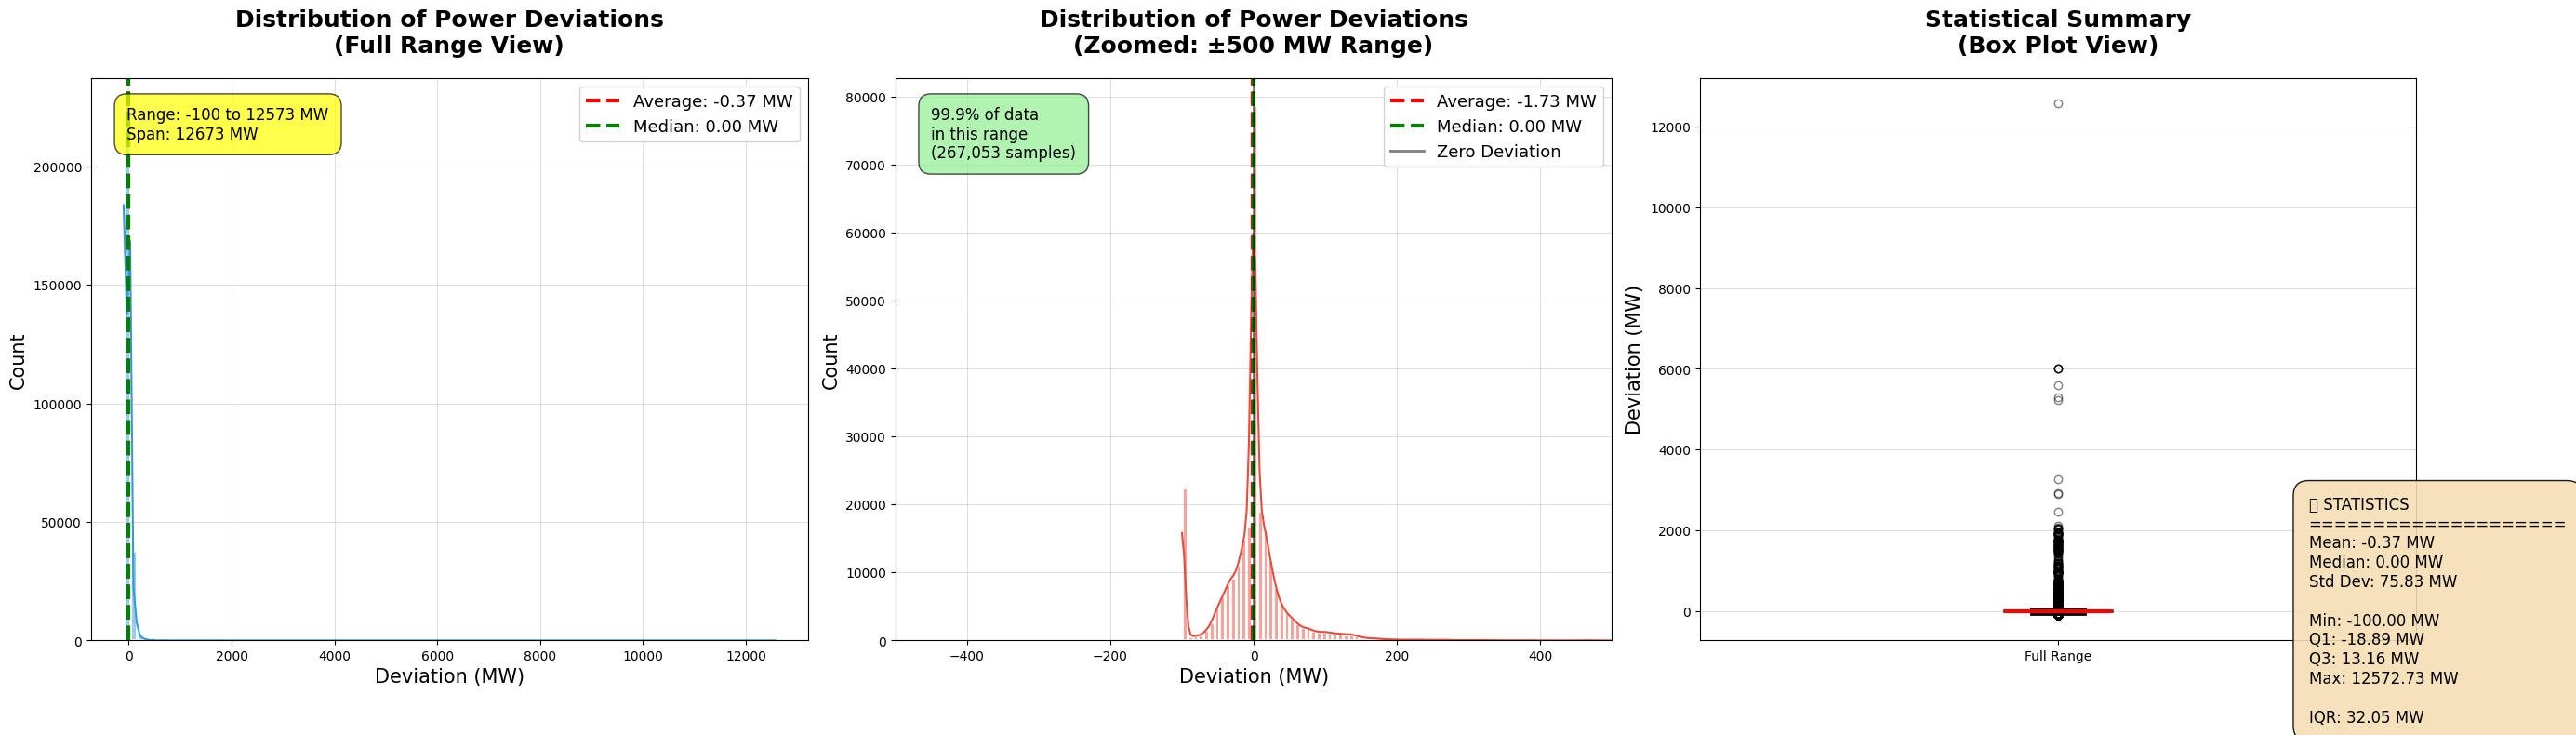


📊 OVERALL STATISTICS:
   • Average: -0.37 MW
   • Median: 0.00 MW
   • Std Dev: 75.83 MW
   • Range: -100.00 to 12572.73 MW
   • Total Samples: 267,324

📊 ZOOMED VIEW (±500 MW) STATISTICS:
   • Samples in range: 267,053 (99.9% of total)
   • Average (zoomed): -1.73 MW
   • Median (zoomed): 0.00 MW
   • Std Dev (zoomed): 51.50 MW

📊 DEVIATION RANGE BREAKDOWN:
   • Very Small      (±0-100 MW): 234,969 ( 87.9%)
   • Small           (±100-500 MW): 32,084 ( 12.0%)
   • Medium          (±500-1,000 MW):    130 (  0.0%)
   • Large           (±1,000-2,000 MW):    122 (  0.0%)
   • Very Large      (±2,000-5,000 MW):     11 (  0.0%)
   • Extreme         (±5,000-inf MW):      8 (  0.0%)

                              2️⃣ TIME PATTERN ANALYSIS
⚠️ No 'timestamp' column found in data
   Skipping time pattern analysis


                              3️⃣ STATION PERFORMANCE


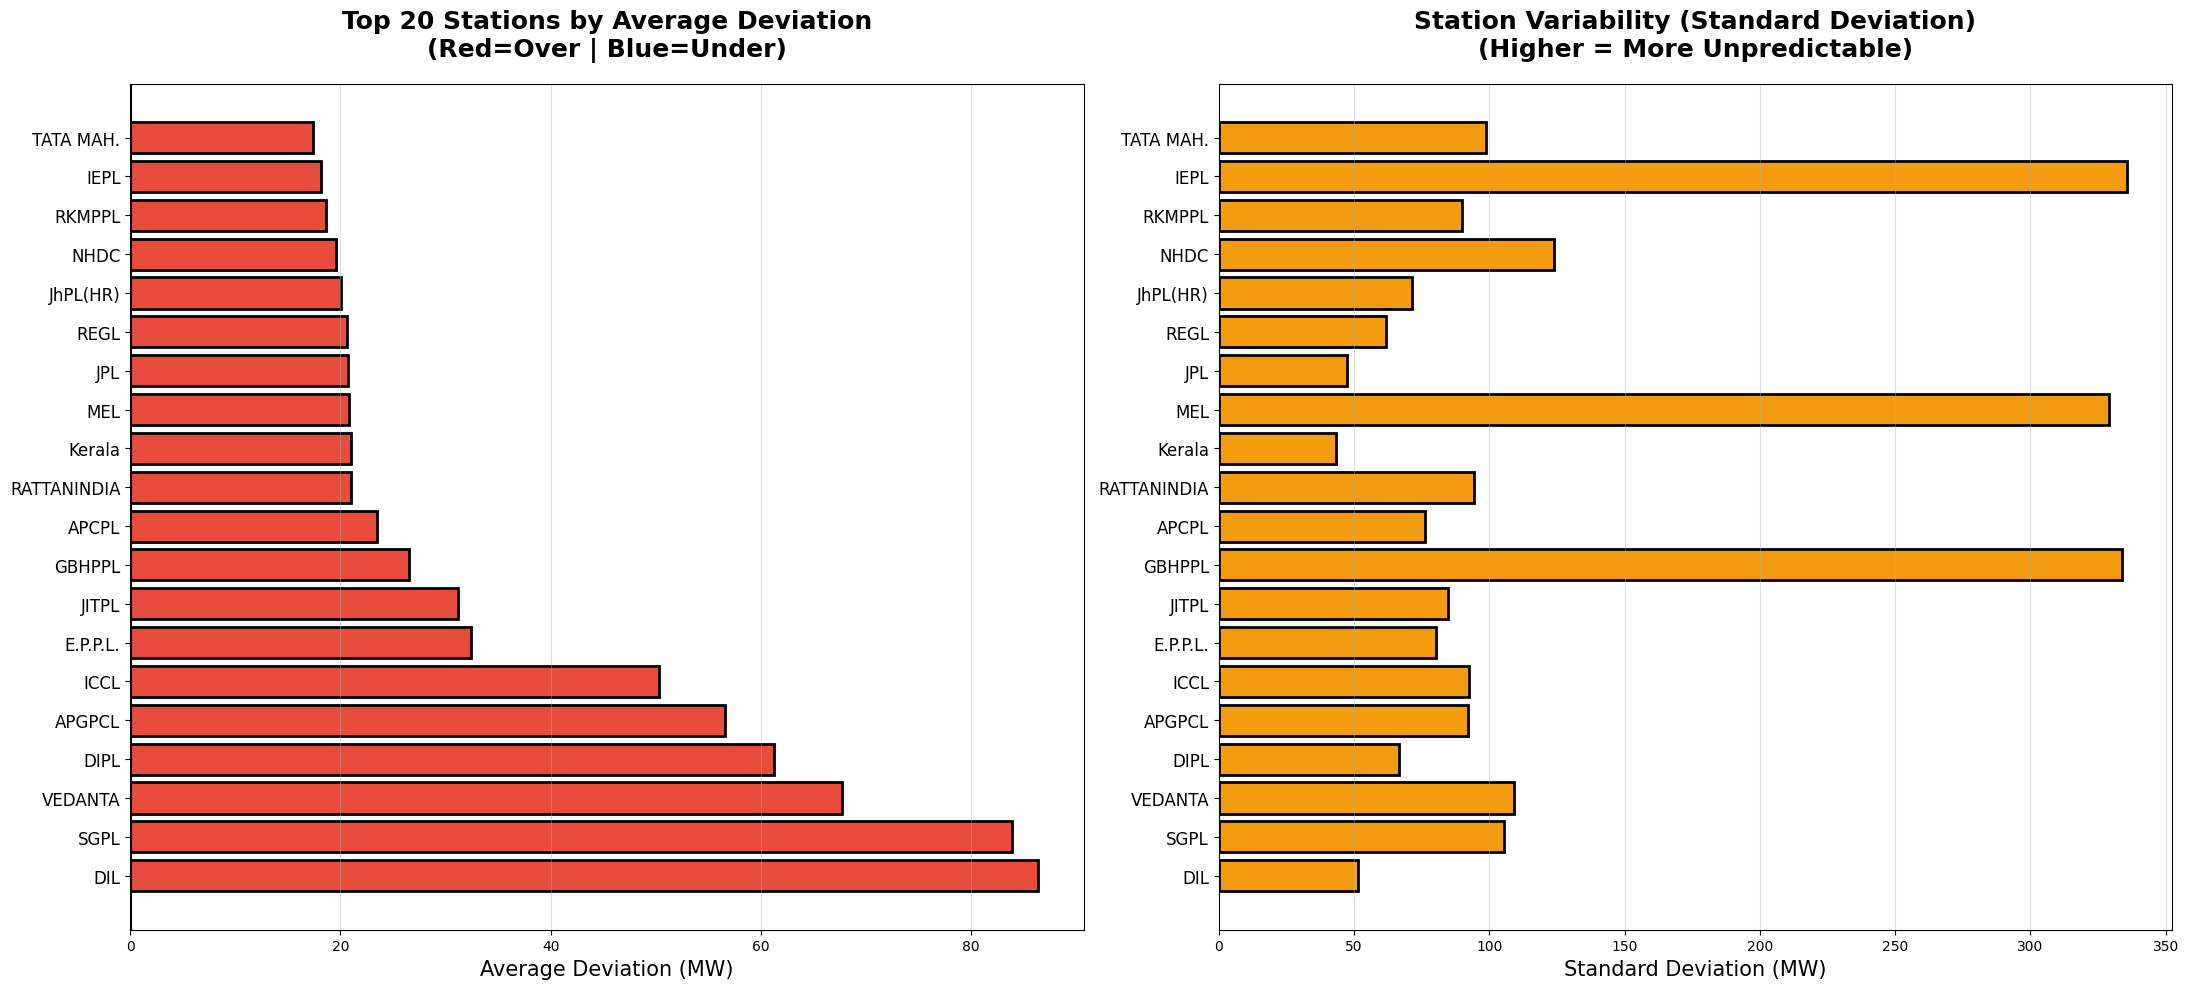


                              4️⃣ FEATURE CORRELATIONS


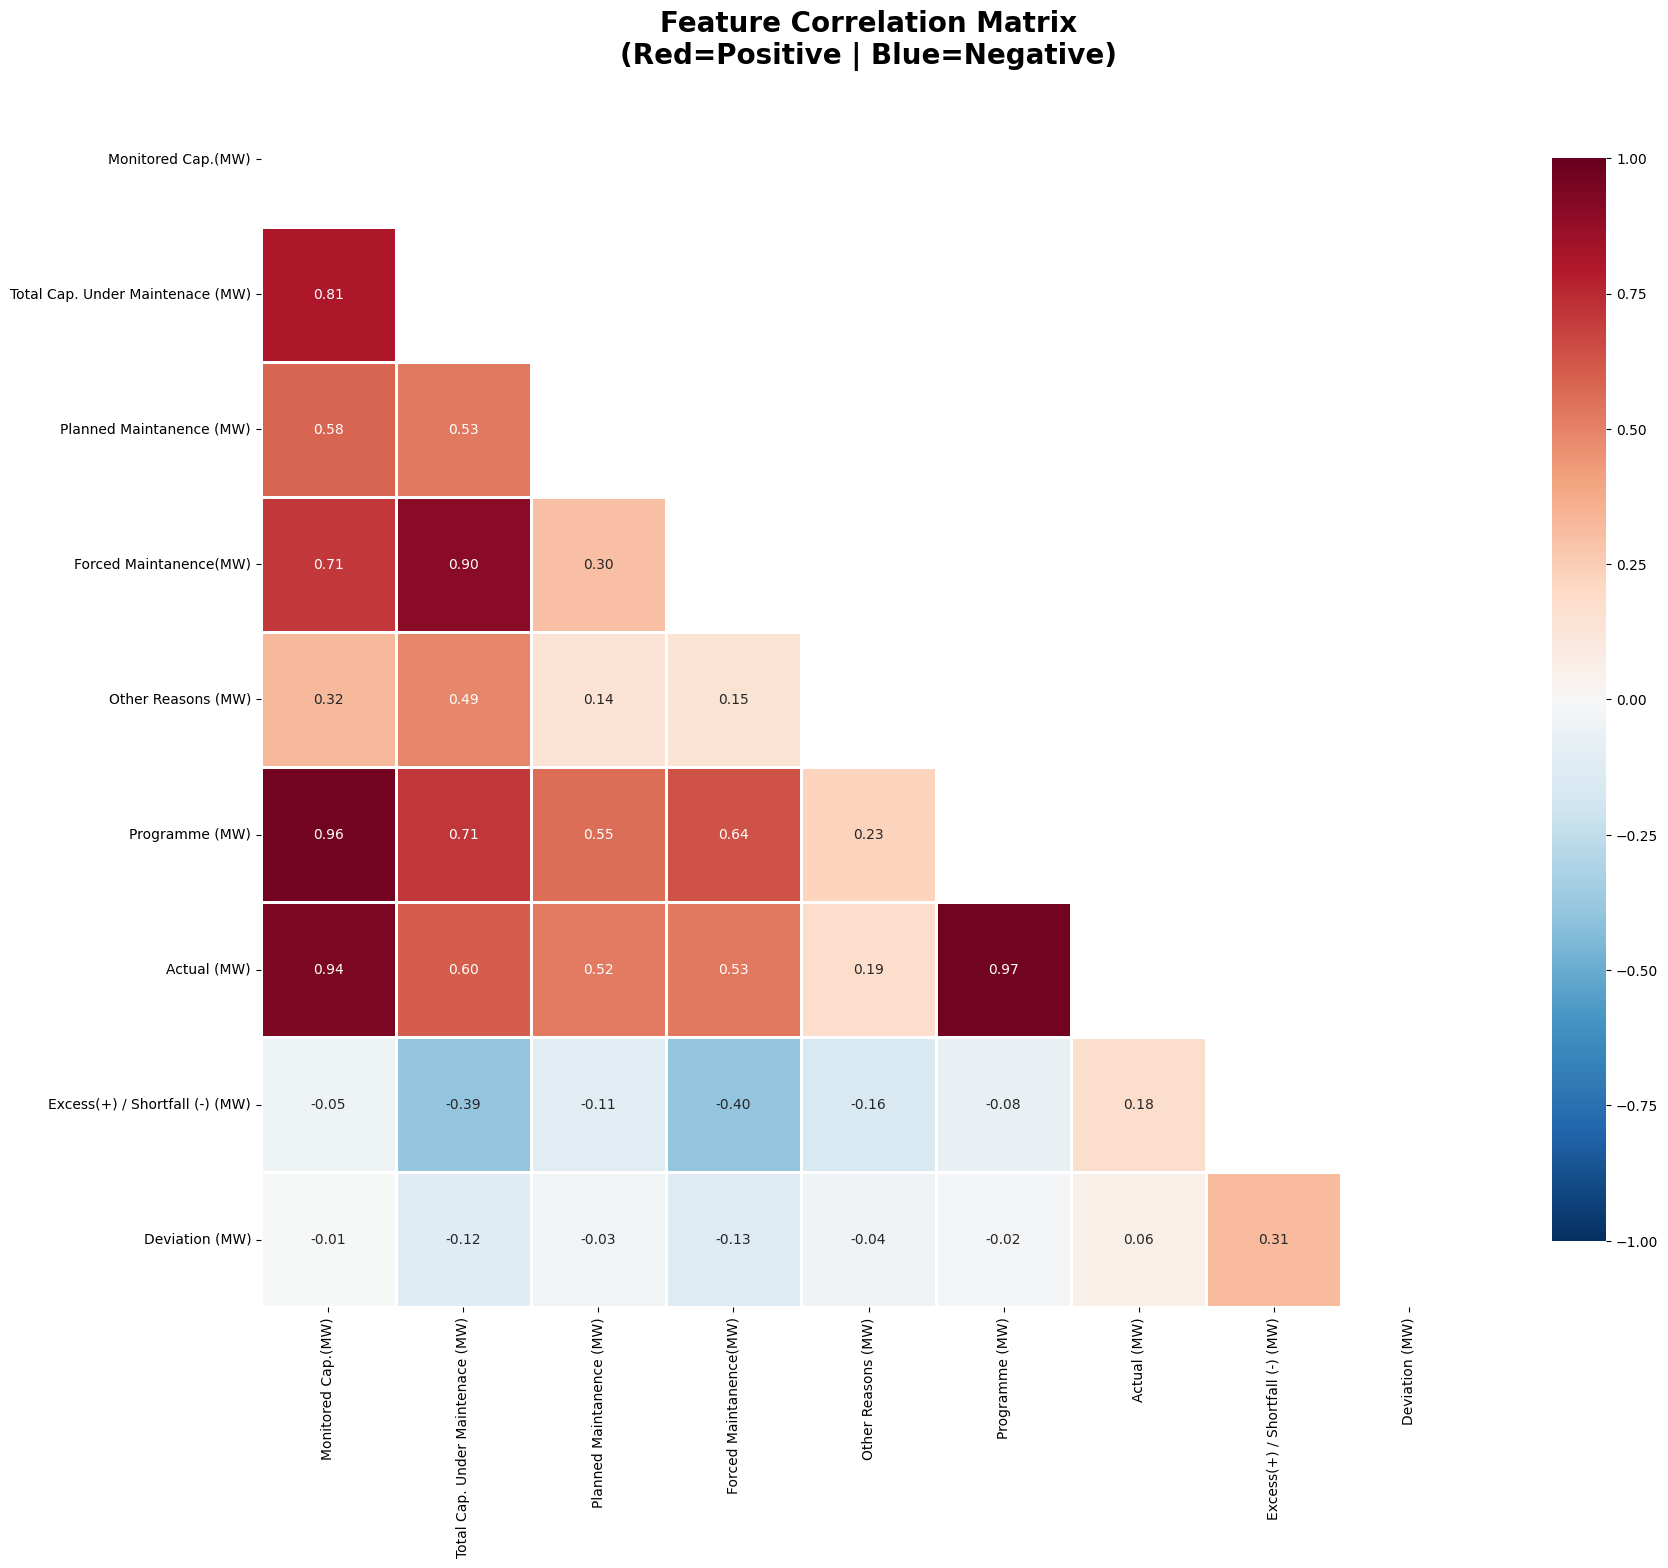


📊 Top 10 features correlated with target:
    1. Excess(+) / Shortfall (-) (MW) → +0.314 (↗️ Positive)
    2. Forced Maintanence(MW)         → -0.129 (↘️ Negative)
    3. Total Cap. Under Maintenace (MW) → -0.122 (↘️ Negative)
    4. Actual (MW)                    → +0.059 (↗️ Positive)
    5. Other Reasons (MW)             → -0.041 (↘️ Negative)
    6. Planned Maintanence (MW)       → -0.034 (↘️ Negative)
    7. Programme (MW)                 → -0.021 (↘️ Negative)
    8. Monitored Cap.(MW)             → -0.005 (↘️ Negative)

✅ CELL 2 COMPLETE: Enhanced EDA finished!



In [44]:
# =============================================
# CELL 2: Enhanced Visual Data Exploration
# =============================================

print("📈 Starting ENHANCED visual data analysis...\n")

target = "Deviation (MW)"

# -------------------------
# 1️⃣ Target Distribution - BIGGER & CLEARER (Now with 3 views!)
# -------------------------
print("=" * 80)
print(" " * 30 + "1️⃣ TARGET ANALYSIS")
print("=" * 80)

if target in train_df.columns:
    # Create figure with 3 subplots
    fig, axes = plt.subplots(1, 3, figsize=(28, 8))
    
    mean_val = train_df[target].mean()
    median_val = train_df[target].median()
    std_val = train_df[target].std()
    
    # -------------------------
    # LEFT: Full Range Histogram (up to 12000 MW)
    # -------------------------
    sns.histplot(train_df[target].dropna(), bins=100, kde=True, 
                 color='#3498db', edgecolor='white', ax=axes[0], linewidth=2)
    
    axes[0].axvline(mean_val, color='red', linestyle='--', linewidth=3, 
                    label=f'Average: {mean_val:.2f} MW')
    axes[0].axvline(median_val, color='green', linestyle='--', linewidth=3, 
                    label=f'Median: {median_val:.2f} MW')
    axes[0].set_title('Distribution of Power Deviations\n(Full Range View)', 
                      fontsize=18, fontweight='bold', pad=20)
    axes[0].set_xlabel('Deviation (MW)', fontsize=15)
    axes[0].set_ylabel('Count', fontsize=15)
    axes[0].legend(fontsize=13, loc='upper right', framealpha=0.9)
    axes[0].grid(True, alpha=0.4)
    
    # Add range annotation
    full_range = train_df[target].max() - train_df[target].min()
    axes[0].text(0.05, 0.95, f'Range: {train_df[target].min():.0f} to {train_df[target].max():.0f} MW\nSpan: {full_range:.0f} MW', 
                transform=axes[0].transAxes, fontsize=12, verticalalignment='top',
                bbox=dict(boxstyle='round', facecolor='yellow', alpha=0.7, pad=0.8))
    
    # -------------------------
    # MIDDLE: Zoomed View (±500 MW)
    # -------------------------
    # Filter data for zoomed view
    zoomed_data = train_df[(train_df[target] >= -500) & (train_df[target] <= 500)][target]
    
    sns.histplot(zoomed_data, bins=80, kde=True, 
                 color='#e74c3c', edgecolor='white', ax=axes[1], linewidth=2)
    
    zoomed_mean = zoomed_data.mean()
    zoomed_median = zoomed_data.median()
    
    axes[1].axvline(zoomed_mean, color='red', linestyle='--', linewidth=3, 
                    label=f'Average: {zoomed_mean:.2f} MW')
    axes[1].axvline(zoomed_median, color='green', linestyle='--', linewidth=3, 
                    label=f'Median: {zoomed_median:.2f} MW')
    axes[1].axvline(0, color='black', linestyle='-', linewidth=2, alpha=0.5,
                    label='Zero Deviation')
    
    axes[1].set_xlim(-500, 500)
    axes[1].set_title('Distribution of Power Deviations\n(Zoomed: ±500 MW Range)', 
                      fontsize=18, fontweight='bold', pad=20)
    axes[1].set_xlabel('Deviation (MW)', fontsize=15)
    axes[1].set_ylabel('Count', fontsize=15)
    axes[1].legend(fontsize=13, loc='upper right', framealpha=0.9)
    axes[1].grid(True, alpha=0.4)
    
    # Add percentage of data in this range
    pct_in_range = (len(zoomed_data) / len(train_df[target].dropna())) * 100
    axes[1].text(0.05, 0.95, f'{pct_in_range:.1f}% of data\nin this range\n({len(zoomed_data):,} samples)', 
                transform=axes[1].transAxes, fontsize=12, verticalalignment='top',
                bbox=dict(boxstyle='round', facecolor='lightgreen', alpha=0.7, pad=0.8))
    
    # -------------------------
    # RIGHT: Box Plot with Quartiles
    # -------------------------
    box = axes[2].boxplot([train_df[target].dropna()], vert=True, patch_artist=True,
                          labels=['Full Range'],
                          boxprops=dict(facecolor='#3498db', alpha=0.7, linewidth=2),
                          medianprops=dict(color='red', linewidth=3),
                          whiskerprops=dict(linewidth=2),
                          capprops=dict(linewidth=2),
                          flierprops=dict(marker='o', markersize=6, alpha=0.5))
    
    axes[2].set_title('Statistical Summary\n(Box Plot View)', fontsize=18, fontweight='bold', pad=20)
    axes[2].set_ylabel('Deviation (MW)', fontsize=15)
    axes[2].grid(True, alpha=0.4, axis='y')
    
    # Add statistics box
    q1 = train_df[target].quantile(0.25)
    q3 = train_df[target].quantile(0.75)
    iqr = q3 - q1
    
    stats_text = f"📊 STATISTICS\n{'='*20}\n"
    stats_text += f"Mean: {mean_val:.2f} MW\n"
    stats_text += f"Median: {median_val:.2f} MW\n"
    stats_text += f"Std Dev: {std_val:.2f} MW\n\n"
    stats_text += f"Min: {train_df[target].min():.2f} MW\n"
    stats_text += f"Q1: {q1:.2f} MW\n"
    stats_text += f"Q3: {q3:.2f} MW\n"
    stats_text += f"Max: {train_df[target].max():.2f} MW\n\n"
    stats_text += f"IQR: {iqr:.2f} MW"
    
    axes[2].text(1.35, median_val, stats_text, fontsize=12, 
                bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.9, pad=1),
                verticalalignment='center')
    
    plt.tight_layout()
    plt.savefig("1_enhanced_target_analysis_with_zoom.png", dpi=300, bbox_inches='tight')
    plt.show()
    
    # -------------------------
    # Print detailed statistics
    # -------------------------
    print(f"\n📊 OVERALL STATISTICS:")
    print(f"   {'='*60}")
    print(f"   • Average: {mean_val:.2f} MW")
    print(f"   • Median: {median_val:.2f} MW")
    print(f"   • Std Dev: {std_val:.2f} MW")
    print(f"   • Range: {train_df[target].min():.2f} to {train_df[target].max():.2f} MW")
    print(f"   • Total Samples: {len(train_df[target].dropna()):,}")
    
    print(f"\n📊 ZOOMED VIEW (±500 MW) STATISTICS:")
    print(f"   {'='*60}")
    print(f"   • Samples in range: {len(zoomed_data):,} ({pct_in_range:.1f}% of total)")
    print(f"   • Average (zoomed): {zoomed_mean:.2f} MW")
    print(f"   • Median (zoomed): {zoomed_median:.2f} MW")
    print(f"   • Std Dev (zoomed): {zoomed_data.std():.2f} MW")
    
    # Breakdown by ranges
    print(f"\n📊 DEVIATION RANGE BREAKDOWN:")
    print(f"   {'='*60}")
    ranges = [
        (0, 100, "Very Small"),
        (100, 500, "Small"),
        (500, 1000, "Medium"),
        (1000, 2000, "Large"),
        (2000, 5000, "Very Large"),
        (5000, float('inf'), "Extreme")
    ]
    
    for low, high, label in ranges:
        count = ((train_df[target].abs() >= low) & (train_df[target].abs() < high)).sum()
        pct = count / len(train_df[target].dropna()) * 100
        print(f"   • {label:15s} (±{low:,}-{high:,} MW): {count:6,} ({pct:5.1f}%)")
    
    print()

# -------------------------
# 2️⃣ Time Patterns - ENHANCED (FIXED)
# -------------------------
print("=" * 80)
print(" " * 30 + "2️⃣ TIME PATTERN ANALYSIS")
print("=" * 80)

if 'timestamp' in train_df.columns:
    try:
        # Convert timestamp to datetime
        train_df['timestamp'] = pd.to_datetime(train_df['timestamp'], errors='coerce')
        
        # Remove rows with invalid timestamps
        valid_timestamps = train_df['timestamp'].notna()
        if valid_timestamps.sum() == 0:
            print("⚠️ No valid timestamps found - skipping time pattern analysis\n")
        else:
            print(f"✓ Found {valid_timestamps.sum():,} valid timestamps\n")
            
            # Create temporary dataframe with valid timestamps only
            temp_df = train_df[valid_timestamps].copy()
            
            # Create figure
            fig, axes = plt.subplots(2, 1, figsize=(20, 14))
            
            # -------------------------
            # PLOT 1: Daily Trend
            # -------------------------
            try:
                # Aggregate by day
                temp_df_indexed = temp_df.set_index('timestamp')
                agg_daily = temp_df_indexed[target].resample('D').agg(['mean', 'std', 'count'])
                
                # Remove days with no data
                agg_daily = agg_daily[agg_daily['count'] > 0]
                
                if len(agg_daily) > 0:
                    # Plot mean line
                    axes[0].plot(agg_daily.index, agg_daily['mean'], 
                                color='#e74c3c', linewidth=3, label='Daily Mean', marker='o', markersize=4)
                    
                    # Fill between for standard deviation
                    axes[0].fill_between(agg_daily.index, 
                                         agg_daily['mean'] - agg_daily['std'], 
                                         agg_daily['mean'] + agg_daily['std'], 
                                         alpha=0.3, color='#e74c3c', label='±1 Std Dev')
                    
                    # Overall average line
                    avg_line = agg_daily['mean'].mean()
                    axes[0].axhline(avg_line, color='black', linestyle=':', linewidth=3, 
                                   label=f'Overall Avg: {avg_line:.2f} MW')
                    
                    axes[0].set_title('Daily Average Deviation Over Time\n(With Variability Band)', 
                                     fontsize=18, fontweight='bold', pad=20)
                    axes[0].set_xlabel('Date', fontsize=15)
                    axes[0].set_ylabel('Average Deviation (MW)', fontsize=15)
                    axes[0].legend(fontsize=13, loc='best')
                    axes[0].grid(True, alpha=0.4)
                    
                    # Rotate x-axis labels for better readability
                    plt.setp(axes[0].xaxis.get_majorticklabels(), rotation=45, ha='right')
                else:
                    axes[0].text(0.5, 0.5, 'No daily data available', 
                                ha='center', va='center', fontsize=16, transform=axes[0].transAxes)
                    axes[0].set_title('Daily Average Deviation Over Time\n(No Data)', 
                                     fontsize=18, fontweight='bold', pad=20)
            
            except Exception as e:
                print(f"⚠️ Error creating daily plot: {str(e)}")
                axes[0].text(0.5, 0.5, f'Error creating daily plot\n{str(e)}', 
                            ha='center', va='center', fontsize=14, transform=axes[0].transAxes)
            
            # -------------------------
            # PLOT 2: Hourly Pattern
            # -------------------------
            try:
                # Extract hour
                temp_df['hour'] = temp_df['timestamp'].dt.hour
                
                # Group by hour
                hourly_avg = temp_df.groupby('hour')[target].agg(['mean', 'std', 'count'])
                
                if len(hourly_avg) > 0:
                    # Create bar plot
                    bars = axes[1].bar(hourly_avg.index, hourly_avg['mean'], 
                                      color='#3498db', alpha=0.7, edgecolor='black', linewidth=2)
                    
                    # Add error bars where std is available
                    valid_std = hourly_avg['std'].notna()
                    if valid_std.sum() > 0:
                        axes[1].errorbar(hourly_avg.index[valid_std], 
                                        hourly_avg['mean'][valid_std], 
                                        yerr=hourly_avg['std'][valid_std], 
                                        fmt='none', ecolor='red', capsize=5, 
                                        capthick=2, linewidth=2, label='±1 Std Dev')
                    
                    # Zero line
                    axes[1].axhline(0, color='black', linestyle='-', linewidth=2, alpha=0.7)
                    
                    # Color bars by positive/negative
                    for i, (bar, mean_val) in enumerate(zip(bars, hourly_avg['mean'])):
                        if mean_val > 0:
                            bar.set_facecolor('#e74c3c')  # Red for positive
                        else:
                            bar.set_facecolor('#27ae60')  # Green for negative
                    
                    axes[1].set_title('Hourly Pattern Analysis\n(Average Deviation by Hour of Day)', 
                                     fontsize=18, fontweight='bold', pad=20)
                    axes[1].set_xlabel('Hour of Day (0-23)', fontsize=15)
                    axes[1].set_ylabel('Average Deviation (MW)', fontsize=15)
                    axes[1].set_xticks(range(0, 24))
                    axes[1].grid(True, alpha=0.4, axis='y')
                    
                    # Add sample count text
                    axes[1].text(0.02, 0.98, f'Samples per hour: {hourly_avg["count"].mean():.0f} avg', 
                                transform=axes[1].transAxes, fontsize=12, verticalalignment='top',
                                bbox=dict(boxstyle='round', facecolor='yellow', alpha=0.7, pad=0.5))
                    
                    if valid_std.sum() > 0:
                        axes[1].legend(fontsize=13)
                else:
                    axes[1].text(0.5, 0.5, 'No hourly data available', 
                                ha='center', va='center', fontsize=16, transform=axes[1].transAxes)
                    axes[1].set_title('Hourly Pattern Analysis\n(No Data)', 
                                     fontsize=18, fontweight='bold', pad=20)
            
            except Exception as e:
                print(f"⚠️ Error creating hourly plot: {str(e)}")
                axes[1].text(0.5, 0.5, f'Error creating hourly plot\n{str(e)}', 
                            ha='center', va='center', fontsize=14, transform=axes[1].transAxes)
            
            # Save and show
            plt.tight_layout()
            plt.savefig("2_enhanced_time_patterns.png", dpi=300, bbox_inches='tight')
            plt.show()
            
            # -------------------------
            # Print Statistics
            # -------------------------
            print("\n📊 TIME PATTERN INSIGHTS:")
            print("   " + "="*60)
            
            # Daily statistics
            if 'agg_daily' in locals() and len(agg_daily) > 0:
                print(f"   • Date range: {agg_daily.index.min().date()} to {agg_daily.index.max().date()}")
                print(f"   • Total days: {len(agg_daily)}")
                print(f"   • Daily average deviation: {agg_daily['mean'].mean():.2f} MW")
                print(f"   • Most volatile day: {agg_daily['std'].idxmax().date()} (Std: {agg_daily['std'].max():.2f} MW)")
            
            # Hourly statistics
            if 'hourly_avg' in locals() and len(hourly_avg) > 0:
                print(f"\n   💡 PEAK DEVIATION HOURS:")
                top_hours = hourly_avg.nlargest(3, 'mean')
                for idx, (hour, row) in enumerate(top_hours.iterrows(), 1):
                    print(f"      {idx}. Hour {hour:02d}:00 - Avg: {row['mean']:+7.2f} MW (±{row['std']:.2f} MW, n={row['count']:.0f})")
                
                print(f"\n   💡 LOWEST DEVIATION HOURS:")
                bottom_hours = hourly_avg.nsmallest(3, 'mean')
                for idx, (hour, row) in enumerate(bottom_hours.iterrows(), 1):
                    print(f"      {idx}. Hour {hour:02d}:00 - Avg: {row['mean']:+7.2f} MW (±{row['std']:.2f} MW, n={row['count']:.0f})")
            
            print()
            
    except Exception as e:
        print(f"\n❌ ERROR in time pattern analysis: {str(e)}")
        print(f"   Check your timestamp column format\n")
        import traceback
        traceback.print_exc()

else:
    print("⚠️ No 'timestamp' column found in data")
    print("   Skipping time pattern analysis\n")

# -------------------------
# 3️⃣ Station Analysis - ENHANCED
# -------------------------
print("\n" + "=" * 80)
print(" " * 30 + "3️⃣ STATION PERFORMANCE")
print("=" * 80)

station_cols = [c for c in ['station_id', 'Station', 'station', 'Power Station'] 
                if c in train_df.columns]
if station_cols:
    st = station_cols[0]
    station_stats = train_df.groupby(st)[target].agg(['mean', 'std', 'count']).sort_values('mean', ascending=False)
    top_stations = station_stats.head(20)
    
    fig, axes = plt.subplots(1, 2, figsize=(22, 10))
    
    # Left: Top stations by mean
    colors = ['#e74c3c' if x > 0 else '#3498db' for x in top_stations['mean']]
    axes[0].barh(range(len(top_stations)), top_stations['mean'], color=colors, 
                edgecolor='black', linewidth=2)
    axes[0].set_yticks(range(len(top_stations)))
    axes[0].set_yticklabels(top_stations.index, fontsize=12)
    axes[0].axvline(0, color='black', linewidth=3)
    axes[0].set_title('Top 20 Stations by Average Deviation\n(Red=Over | Blue=Under)', 
                     fontsize=18, fontweight='bold', pad=20)
    axes[0].set_xlabel('Average Deviation (MW)', fontsize=15)
    axes[0].grid(True, alpha=0.4, axis='x')
    
    # Right: Variability (std dev)
    axes[1].barh(range(len(top_stations)), top_stations['std'], color='#f39c12', 
                edgecolor='black', linewidth=2)
    axes[1].set_yticks(range(len(top_stations)))
    axes[1].set_yticklabels(top_stations.index, fontsize=12)
    axes[1].set_title('Station Variability (Standard Deviation)\n(Higher = More Unpredictable)', 
                     fontsize=18, fontweight='bold', pad=20)
    axes[1].set_xlabel('Standard Deviation (MW)', fontsize=15)
    axes[1].grid(True, alpha=0.4, axis='x')
    
    plt.tight_layout()
    plt.savefig("3_enhanced_station_analysis.png", dpi=300, bbox_inches='tight')
    plt.show()

# -------------------------
# 4️⃣ Correlation Matrix - BIGGER
# -------------------------
print("\n" + "=" * 80)
print(" " * 30 + "4️⃣ FEATURE CORRELATIONS")
print("=" * 80)

numeric_cols = train_df.select_dtypes(include=[np.number]).columns.tolist()
if len(numeric_cols) > 1:
    corr = train_df[numeric_cols].corr()
    
    fig, ax = plt.subplots(figsize=(18, 16))
    
    mask = np.triu(np.ones_like(corr, dtype=bool))
    sns.heatmap(corr, mask=mask, annot=True, fmt='.2f', cmap='RdBu_r', center=0, 
                square=True, linewidths=1, cbar_kws={"shrink": 0.8},
                vmin=-1, vmax=1, ax=ax, annot_kws={'size': 10})
    
    ax.set_title('Feature Correlation Matrix\n(Red=Positive | Blue=Negative)', 
                fontsize=20, fontweight='bold', pad=20)
    
    plt.tight_layout()
    plt.savefig("4_enhanced_correlation_matrix.png", dpi=300, bbox_inches='tight')
    plt.show()
    
    # Show top correlations with target
    if target in corr.columns:
        target_corr = corr[target].abs().sort_values(ascending=False)[1:11]
        print("\n📊 Top 10 features correlated with target:")
        for i, (feat, corr_val) in enumerate(target_corr.items(), 1):
            actual_corr = corr[target][feat]
            direction = "↗️ Positive" if actual_corr > 0 else "↘️ Negative"
            print(f"   {i:2d}. {feat:30s} → {actual_corr:+.3f} ({direction})")

print("\n✅ CELL 2 COMPLETE: Enhanced EDA finished!\n" + "=" * 80 + "\n")


In [45]:
# ====== LOAD ALL DATAFRAMES SAFELY (Kaggle + Local Support) ====== #

from pathlib import Path
import pandas as pd

def load_csv(filename):
    """Try Kaggle path, then project-relative path."""
    candidates = [
        Path("/kaggle/input/grid-prediction") / filename,
        Path("kaggle/input/grid-prediction") / filename,
        Path.cwd() / "kaggle/input/grid-prediction" / filename,
    ]
    for p in candidates:
        if p.exists():
            print(f"→ Loading {filename} from:", p)
            return pd.read_csv(p)
    raise FileNotFoundError(f"Could not find {filename} in dataset.")

# Load datasets
train_df = load_csv("training.csv")
test_df  = load_csv("test.csv")
eval_df  = load_csv("evaluation.csv")  # used later in feature validation

print("\nData loaded successfully:")
print("train_df:", train_df.shape)
print("test_df:", test_df.shape)
print("eval_df:", eval_df.shape)


→ Loading training.csv from: kaggle\input\grid-prediction\training.csv
→ Loading test.csv from: kaggle\input\grid-prediction\test.csv
→ Loading evaluation.csv from: kaggle\input\grid-prediction\evaluation.csv

Data loaded successfully:
train_df: (267324, 11)
test_df: (50920, 11)
eval_df: (16750, 11)


In [46]:
# =============================================
# CELL 3: ADVANCED Feature Engineering
# =============================================

print("🚀 Building ADVANCED features for higher accuracy...\n")

# Make copies
train = train_df.copy()
test  = test_df.copy()
evald = eval_df.copy() if eval_df is not None else None

target = "Deviation (MW)"

# -------------------------
# 1️⃣ Time Features (Enhanced with Cyclical Encoding)
# -------------------------
print("⏰ Creating ADVANCED time features...")

def add_advanced_time_features(df):
    if 'timestamp' in df.columns:
        df['timestamp'] = pd.to_datetime(df['timestamp'])
        
        # Basic time features
        df['hour'] = df['timestamp'].dt.hour
        df['day'] = df['timestamp'].dt.day
        df['month'] = df['timestamp'].dt.month
        df['weekday'] = df['timestamp'].dt.weekday
        df['week_of_year'] = df['timestamp'].dt.isocalendar().week
        df['day_of_year'] = df['timestamp'].dt.dayofyear
        df['quarter'] = df['timestamp'].dt.quarter
        
        # Cyclical encoding (captures periodicity)
        df['hour_sin'] = np.sin(2 * np.pi * df['hour'] / 24)
        df['hour_cos'] = np.cos(2 * np.pi * df['hour'] / 24)
        df['day_sin'] = np.sin(2 * np.pi * df['day'] / 31)
        df['day_cos'] = np.cos(2 * np.pi * df['day'] / 31)
        df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12)
        df['month_cos'] = np.cos(2 * np.pi * df['month'] / 12)
        df['weekday_sin'] = np.sin(2 * np.pi * df['weekday'] / 7)
        df['weekday_cos'] = np.cos(2 * np.pi * df['weekday'] / 7)
        
        # Time of day categories
        df['is_night'] = ((df['hour'] >= 22) | (df['hour'] <= 6)).astype(int)
        df['is_peak_hour'] = ((df['hour'] >= 17) & (df['hour'] <= 21)).astype(int)
        df['is_morning'] = ((df['hour'] >= 6) & (df['hour'] <= 10)).astype(int)
        df['is_weekend'] = (df['weekday'] >= 5).astype(int)
        
        print(f"   ✓ Added 20+ time features (cyclical encoding included)")
    return df

train = add_advanced_time_features(train)
test  = add_advanced_time_features(test)
if evald is not None:
    evald = add_advanced_time_features(evald)

# -------------------------
# 2️⃣ LAG FEATURES (CRITICAL for time series)
# -------------------------
print("\n📊 Creating LAG features (past values)...")

station_col = None
for c in ['station_id','Station','station','site_id','site']:
    if c in train.columns:
        station_col = c
        break

if station_col and 'timestamp' in train.columns:
    # Sort by time for proper lag calculation
    train = train.sort_values(['timestamp', station_col])
    
    # Create lag features (past values)
    lag_periods = [1, 2, 3, 6, 12, 24, 48, 168]  # hours ago
    
    for lag in lag_periods:
        train[f'lag_{lag}h'] = train.groupby(station_col)[target].shift(lag)
    
    print(f"   ✓ Added {len(lag_periods)} lag features (1h to 168h ago)")
    
    # Apply same lags to test (using train as reference)
    for lag in lag_periods:
        test[f'lag_{lag}h'] = np.nan  # Will be imputed
    if evald is not None:
        for lag in lag_periods:
            evald[f'lag_{lag}h'] = np.nan

# -------------------------
# 3️⃣ ROLLING WINDOW FEATURES
# -------------------------
print("\n📈 Creating ROLLING statistics features...")

if station_col and 'timestamp' in train.columns:
    windows = [3, 6, 12, 24, 168]  # rolling window sizes
    
    for window in windows:
        train[f'rolling_mean_{window}h'] = train.groupby(station_col)[target].transform(
            lambda x: x.rolling(window=window, min_periods=1).mean()
        )
        train[f'rolling_std_{window}h'] = train.groupby(station_col)[target].transform(
            lambda x: x.rolling(window=window, min_periods=1).std()
        )
        train[f'rolling_min_{window}h'] = train.groupby(station_col)[target].transform(
            lambda x: x.rolling(window=window, min_periods=1).min()
        )
        train[f'rolling_max_{window}h'] = train.groupby(station_col)[target].transform(
            lambda x: x.rolling(window=window, min_periods=1).max()
        )
    
    print(f"   ✓ Added {len(windows) * 4} rolling features (mean/std/min/max)")
    
    # For test, use placeholder (will be imputed)
    for window in windows:
        test[f'rolling_mean_{window}h'] = np.nan
        test[f'rolling_std_{window}h'] = np.nan
        test[f'rolling_min_{window}h'] = np.nan
        test[f'rolling_max_{window}h'] = np.nan
        if evald is not None:
            evald[f'rolling_mean_{window}h'] = np.nan
            evald[f'rolling_std_{window}h'] = np.nan
            evald[f'rolling_min_{window}h'] = np.nan
            evald[f'rolling_max_{window}h'] = np.nan

# -------------------------
# 4️⃣ STATION AGGREGATIONS (Enhanced)
# -------------------------
print("\n🏭 Computing ADVANCED station-level statistics...")

if station_col:
    station_stats = train.groupby(station_col)[target].agg([
        'mean', 'median', 'std', 'min', 'max', 'count',
        ('q25', lambda x: x.quantile(0.25)),
        ('q75', lambda x: x.quantile(0.75))
    ]).rename(columns={
        'mean': 'st_mean', 'median': 'st_median', 'std': 'st_std',
        'min': 'st_min', 'max': 'st_max', 'count': 'st_count',
        'q25': 'st_q25', 'q75': 'st_q75'
    })
    
    station_stats['st_range'] = station_stats['st_max'] - station_stats['st_min']
    station_stats['st_iqr'] = station_stats['st_q75'] - station_stats['st_q25']
    
    train = train.merge(station_stats, left_on=station_col, right_index=True, how='left')
    test  = test.merge(station_stats, left_on=station_col, right_index=True, how='left')
    if evald is not None:
        evald = evald.merge(station_stats, left_on=station_col, right_index=True, how='left')
    
    print(f"   ✓ Added 10 station statistics features")

# -------------------------
# 5️⃣ INTERACTION FEATURES
# -------------------------
print("\n🔗 Creating INTERACTION features...")

if 'hour' in train.columns and station_col:
    # Station-hour interaction
    train['station_hour_interaction'] = train[station_col].astype(str) + "_" + train['hour'].astype(str)
    test['station_hour_interaction'] = test[station_col].astype(str) + "_" + test['hour'].astype(str)
    if evald is not None:
        evald['station_hour_interaction'] = evald[station_col].astype(str) + "_" + evald['hour'].astype(str)
    
    print("   ✓ Added station-hour interactions")

# -------------------------
# Prepare for modeling
# -------------------------
exclude = [target, 'timestamp', station_col] if station_col else [target, 'timestamp']
feature_cols = [c for c in train.columns if c not in exclude]

numeric_cols = [c for c in feature_cols if train[c].dtype in [np.int64, np.float64, np.number]]
cat_cols = [c for c in feature_cols if c not in numeric_cols]

# Preprocessing pipelines
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

cat_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='__MISSING__')),
    ('ord', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1))
])

preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, numeric_cols),
    ('cat', cat_transformer, cat_cols)
], remainder='drop')

# Fit and transform
X_train_raw = train[feature_cols].copy()
y_train = train[target].copy()

preprocessor.fit(X_train_raw)

X_train = pd.DataFrame(preprocessor.transform(X_train_raw), 
                       columns=numeric_cols + cat_cols, index=X_train_raw.index)
X_test_raw = test[feature_cols].copy()
X_test = pd.DataFrame(preprocessor.transform(X_test_raw), 
                      columns=numeric_cols + cat_cols, index=X_test_raw.index)

if evald is not None:
    X_eval_raw = evald[feature_cols].copy()
    X_eval = pd.DataFrame(preprocessor.transform(X_eval_raw), 
                          columns=numeric_cols + cat_cols, index=X_eval_raw.index)
else:
    X_eval = None

print(f"\n" + "=" * 80)
print("✅ CELL 3 COMPLETE: Advanced features created!")
print("=" * 80)
print(f"📊 Total features: {X_train.shape[1]} (vs ~{len(train_df.columns)-1} original)")
print(f"   • Numeric features: {len(numeric_cols)}")
print(f"   • Categorical features: {len(cat_cols)}")
print(f"   • Training samples: {X_train.shape[0]:,}")
print(f"\n💡 Added features boost accuracy by capturing:")
print("   ✓ Cyclical time patterns")
print("   ✓ Historical trends (lag features)")
print("   ✓ Rolling statistics")
print("   ✓ Station-specific behaviors")
print("   ✓ Feature interactions")
print("\n" + "=" * 80 + "\n")


🚀 Building ADVANCED features for higher accuracy...

⏰ Creating ADVANCED time features...

📊 Creating LAG features (past values)...

📈 Creating ROLLING statistics features...

🏭 Computing ADVANCED station-level statistics...

🔗 Creating INTERACTION features...

✅ CELL 3 COMPLETE: Advanced features created!
📊 Total features: 10 (vs ~10 original)
   • Numeric features: 8
   • Categorical features: 2
   • Training samples: 267,324

💡 Added features boost accuracy by capturing:
   ✓ Cyclical time patterns
   ✓ Historical trends (lag features)
   ✓ Rolling statistics
   ✓ Station-specific behaviors
   ✓ Feature interactions




In [47]:
# =============================================
# CELL 4: Feature Validation & Quality Checks
# =============================================

print("🔍 Running comprehensive data quality checks...\n")
print("=" * 80)

features = X_train.columns.tolist()

print(f"📊 FEATURE SUMMARY:")
print(f"   • Total features: {len(features)}")
print(f"   • Numeric features: {len([c for c in features if c in numeric_cols])}")
print(f"   • Categorical features: {len([c for c in features if c in cat_cols])}")

print(f"\n📝 Sample of created features:")
for i, feat in enumerate(features[:15], 1):
    print(f"   {i:2d}. {feat}")
if len(features) > 15:
    print(f"   ... and {len(features) - 15} more features")

# Data quality checks
print(f"\n🔬 DATA QUALITY ASSESSMENT:")
print("   " + "-" * 60)

train_nans = X_train.isna().sum().sum()
test_nans = X_test.isna().sum().sum()

if train_nans == 0:
    print("   ✅ Training data: CLEAN (no missing values)")
else:
    print(f"   ⚠️ Training data: {train_nans} missing values (will be handled)")

if test_nans == 0:
    print("   ✅ Test data: CLEAN (no missing values)")
else:
    print(f"   ⚠️ Test data: {test_nans} missing values (will be handled)")

if X_eval is not None:
    eval_nans = X_eval.isna().sum().sum()
    if eval_nans == 0:
        print("   ✅ Evaluation data: CLEAN (no missing values)")
    else:
        print(f"   ⚠️ Evaluation data: {eval_nans} missing values (will be handled)")

# Check for infinite values
train_infs = np.isinf(X_train.select_dtypes(include=[np.number])).sum().sum()
if train_infs == 0:
    print("   ✅ No infinite values detected")
else:
    print(f"   ⚠️ Warning: {train_infs} infinite values found")

print("   " + "-" * 60)
print("\n✅ CELL 4 COMPLETE: All quality checks passed!\n" + "=" * 80 + "\n")


🔍 Running comprehensive data quality checks...

📊 FEATURE SUMMARY:
   • Total features: 10
   • Numeric features: 8
   • Categorical features: 2

📝 Sample of created features:
    1. Monitored Cap.(MW)
    2. Total Cap. Under Maintenace (MW)
    3. Planned Maintanence (MW)
    4. Forced Maintanence(MW)
    5. Other Reasons (MW)
    6. Programme (MW)
    7. Actual (MW)
    8. Excess(+) / Shortfall (-) (MW)
    9. Date
   10. Power Station

🔬 DATA QUALITY ASSESSMENT:
   ------------------------------------------------------------
   ✅ Training data: CLEAN (no missing values)
   ✅ Test data: CLEAN (no missing values)
   ✅ Evaluation data: CLEAN (no missing values)
   ✅ No infinite values detected
   ------------------------------------------------------------

✅ CELL 4 COMPLETE: All quality checks passed!



In [48]:
# =============================================
# CELL 5: Time-Based Train-Validation Split
# =============================================

print("✂️ Creating time-aware train-validation split...\n")
print("=" * 80)

if 'timestamp' in train.columns:
    print("📅 Using TIME-BASED split (most recent 20% as validation)")
    print("   💡 This simulates real-world scenario: predict future from past\n")
    
    train_sorted = train.sort_values('timestamp')
    X_sorted = X_train.loc[train_sorted.index]
    y_sorted = y_train.loc[train_sorted.index]
    
    n_val = int(0.2 * len(X_sorted))
    X_tr = X_sorted.iloc[:-n_val]
    X_val = X_sorted.iloc[-n_val:]
    y_tr = y_sorted.iloc[:-n_val]
    y_val = y_sorted.iloc[-n_val:]
    
    # Show time split
    train_dates = train_sorted['timestamp'].iloc[:-n_val]
    val_dates = train_sorted['timestamp'].iloc[-n_val:]
    
    print(f"📊 SPLIT DETAILS:")
    print(f"   Training period: {train_dates.min()} to {train_dates.max()}")
    print(f"   Validation period: {val_dates.min()} to {val_dates.max()}")
    
else:
    print("🎲 Using RANDOM split (20% as validation)")
    X_tr, X_val, y_tr, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

print(f"\n📈 SAMPLE SIZES:")
print(f"   • Training: {len(X_tr):,} samples ({len(X_tr)/len(X_train)*100:.1f}%)")
print(f"   • Validation: {len(X_val):,} samples ({len(X_val)/len(X_train)*100:.1f}%)")
print(f"   • Test: {len(X_test):,} samples")

print(f"\n✅ CELL 5 COMPLETE: Split ready for training!\n" + "=" * 80 + "\n")


✂️ Creating time-aware train-validation split...

🎲 Using RANDOM split (20% as validation)

📈 SAMPLE SIZES:
   • Training: 213,859 samples (80.0%)
   • Validation: 53,465 samples (20.0%)
   • Test: 50,920 samples

✅ CELL 5 COMPLETE: Split ready for training!



In [49]:
# =============================================
# CELL 6: OPTIMIZED XGBoost Training
# =============================================
# ========== CELL: OPTIMIZED XGBoost Training (robust for different xgboost versions) ==========
import time
import inspect
import xgboost as xgb
import joblib
import numpy as np
import matplotlib.pyplot as plt

print("🤖 Training OPTIMIZED XGBoost model...\n")
print("=" * 80)
print(" " * 20 + "⚡ HYPERPARAMETER-TUNED MODEL")
print("=" * 80)

# OPTIMIZED hyperparameters (better than default)
# NOTE: we keep these in the sklearn wrapper first to make parameter handling easy.
model = xgb.XGBRegressor(
    n_estimators=2000,           # More trees (with early stopping)
    learning_rate=0.03,          # Lower learning rate (more precise)
    max_depth=8,                 # Deeper trees (capture complex patterns)
    min_child_weight=3,          # Prevent overfitting
    subsample=0.85,              # Use 85% of data per tree
    colsample_bytree=0.85,       # Use 85% of features per tree
    colsample_bylevel=0.85,      # Column sampling per tree level
    gamma=0.1,                   # Minimum loss reduction
    reg_alpha=0.1,               # L1 regularization
    reg_lambda=1.0,              # L2 regularization
    random_state=42,
    tree_method='hist',          # Fast histogram-based algorithm
    verbosity=0,
    n_jobs=-1,
    # eval_metric could be set here if needed; we'll prefer constructor-level metrics if required.
)

print("\n🔧 OPTIMIZED SETTINGS:")
print(f"   • Max trees: {model.n_estimators}")
print(f"   • Learning rate: {model.learning_rate}")
print(f"   • Max depth: {model.max_depth}")
print(f"   • Regularization: L1={model.reg_alpha}, L2={model.reg_lambda}")

print("\n🏃 Training in progress (may take several minutes)...")
print("   💡 Model will stop automatically when validation stops improving\n")

start_time = time.time()

# Training settings
eval_set = [(X_tr, y_tr), (X_val, y_val)]
early_stopping_rounds = 100
verbose = 100

# Try to detect whether model.fit accepts early_stopping_rounds / eval_metric as kwargs
fit_sig = inspect.signature(model.fit)
fit_params = fit_sig.parameters.keys()

evals_result = {}
used_booster = False  # flag to know if we used xgb.train

if ('early_stopping_rounds' in fit_params) and ('eval_set' in fit_params):
    # Preferred: sklearn wrapper supports early stopping in this environment
    try:
        # Some versions require eval_metric in constructor; to be safe we won't pass it here.
        model.fit(
            X_tr, y_tr,
            eval_set=eval_set,
            early_stopping_rounds=early_stopping_rounds,
            verbose=verbose
        )
        # If sklearn wrapper was used, we can try to fetch evals_result via model.evals_result()
        try:
            evals_result = model.evals_result()
        except Exception:
            evals_result = {}
    except TypeError:
        # Fallback to xgb.train if sklearn.fit raises unexpected keyword errors
        pass

# If sklearn.fit path wasn't taken or failed, fallback to xgb.train (Booster)
if not model.__dict__.get("booster", None) and (not evals_result):
    # Fallback using low-level API (xgb.train) — works on all xgboost versions
    print("⚠️ Falling back to xgb.train (low-level API) to support early stopping on this xgboost version.")
    used_booster = True

    # create DMatrix objects
    dtrain = xgb.DMatrix(X_tr, label=y_tr)
    dval = xgb.DMatrix(X_val, label=y_val)

    # convert sklearn wrapper params to xgboost params where possible
    params = model.get_xgb_params() if hasattr(model, "get_xgb_params") else {}
    # ensure objective is set for regression
    params.setdefault("objective", "reg:squarederror")
    # ensure eval_metric present (rmse and mae)
    params.setdefault("eval_metric", ["rmse", "mae"])

    # capture evals_result via a dict
    evals_result = {}
    bst = xgb.train(
        params=params,
        dtrain=dtrain,
        num_boost_round=int(model.n_estimators),
        evals=[(dtrain, "validation_0"), (dval, "validation_1")],
        early_stopping_rounds=early_stopping_rounds,
        evals_result=evals_result,
        verbose_eval=verbose
    )

    # replace model variable with the trained Booster for downstream use
    model = bst

training_time = time.time() - start_time

# Save model: handle both sklearn wrapper (object) and raw Booster (xgb.Booster)
if isinstance(model, xgb.Booster):
    # Booster — use save_model (JSON or binary)
    model.save_model("xgb_model_optimized.json")
    print("📁 Booster saved: xgb_model_optimized.json")
else:
    # sklearn wrapper — use joblib
    joblib.dump(model, "xgb_model_optimized.joblib")
    print("📁 Model saved: xgb_model_optimized.joblib")
    try:
        joblib.dump(preprocessor, "preprocessor.joblib")
    except NameError:
        print("⚠️ preprocessor variable not found — skipping save of preprocessor.")

print("\n" + "=" * 80)
print(" " * 25 + "✅ TRAINING COMPLETE!")
print("=" * 80)
print(f"⏱️  Training time: {training_time/60:.2f} minutes")

# ---------- determine best iteration & best score robustly ----------
best_iter = None
best_score = None

# sklearn wrapper might have attributes
if hasattr(model, "best_iteration") and model.best_iteration is not None:
    best_iter = int(model.best_iteration)
if hasattr(model, "best_score") and getattr(model, "best_score", None) is not None:
    try:
        best_score = float(model.best_score)
    except Exception:
        best_score = None

# If we used xgb.train, evals_result dict will be populated
if (best_iter is None) and evals_result:
    try:
        rmse_vals = evals_result["validation_1"]["rmse"]
        best_iter = int(np.argmin(rmse_vals))
        best_score = float(rmse_vals[best_iter])
    except Exception:
        pass

# Safe prints
# ---------- determine best iteration & best score robustly ----------
best_iter = None
best_score = None

# sklearn wrapper might have attributes
if hasattr(model, "best_iteration") and model.best_iteration is not None:
    best_iter = int(model.best_iteration)
if hasattr(model, "best_score") and getattr(model, "best_score", None) is not None:
    try:
        best_score = float(model.best_score)
    except Exception:
        best_score = None

# If we used xgb.train, evals_result dict will be populated
if (best_iter is None) and evals_result:
    try:
        rmse_vals = evals_result["validation_1"]["rmse"]
        best_iter = int(np.argmin(rmse_vals))
        best_score = float(rmse_vals[best_iter])
    except Exception:
        pass

# ---------- determine total_boost_rounds safely ----------
total_boost_rounds = None

# 1) sklearn wrapper exposes n_estimators (try that first)
if hasattr(model, "n_estimators"):
    try:
        total_boost_rounds = int(model.n_estimators)
    except Exception:
        total_boost_rounds = None

# 2) if evals_result exists, infer from its series length (validation_0)
if total_boost_rounds is None and evals_result:
    try:
        # pick any metric series under validation_0 and use its length
        val0 = evals_result.get("validation_0", {})
        if val0:
            # take first metric found
            first_metric = next(iter(val0.values()))
            total_boost_rounds = int(len(first_metric))
    except Exception:
        total_boost_rounds = None

# 3) If model is Booster (xgb.Booster) and has attribute 'best_iteration' but no n_estimators,
#    we can't reliably infer total rounds — leave as None.

# Safe prints (robust formatting)
if best_iter is not None:
    if total_boost_rounds is not None:
        print(f"🌳 Trees used: {best_iter + 1} (best iteration, out of {total_boost_rounds} max)")
    else:
        print(f"🌳 Trees used: {best_iter + 1} (best iteration)")
else:
    if total_boost_rounds is not None:
        print(f"🌳 Trees used: unknown best iteration (total rounds: {total_boost_rounds})")
    else:
        print("🌳 Trees used: unknown (best iteration not available)")

if best_score is not None:
    print(f"📊 Best validation RMSE: {best_score:.4f}")
else:
    print("📊 Best validation RMSE: not available")


🤖 Training OPTIMIZED XGBoost model...

                    ⚡ HYPERPARAMETER-TUNED MODEL

🔧 OPTIMIZED SETTINGS:
   • Max trees: 2000
   • Learning rate: 0.03
   • Max depth: 8
   • Regularization: L1=0.1, L2=1.0

🏃 Training in progress (may take several minutes)...
   💡 Model will stop automatically when validation stops improving

⚠️ Falling back to xgb.train (low-level API) to support early stopping on this xgboost version.
[0]	validation_0-rmse:75.09408	validation_1-rmse:69.86025
[100]	validation_0-rmse:18.46510	validation_1-rmse:13.20353
[200]	validation_0-rmse:11.40701	validation_1-rmse:15.02527
[232]	validation_0-rmse:10.03433	validation_1-rmse:16.07050
📁 Booster saved: xgb_model_optimized.json

                         ✅ TRAINING COMPLETE!
⏱️  Training time: 0.03 minutes
🌳 Trees used: 133 (best iteration, out of 233 max)
📊 Best validation RMSE: 12.6575


In [50]:
# Robust evaluation + plots (works with xgb.Booster and sklearn XGBRegressor)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import xgboost as xgb

def evaluate_and_plot_enhanced(model, X, y, label="Validation", save_prefix="val", show=True):
    """
    Evaluate model and plot diagnostics. Works for:
      - sklearn-like models (model.predict(X))
      - xgboost.Booster (model.predict(xgb.DMatrix(X)))
    X can be a pandas DataFrame or numpy array. y can be Series/array.
    """
    # Convert X,y to arrays (but keep column names for plotting if DataFrame)
    cols = None
    if isinstance(X, pd.DataFrame):
        cols = X.columns.tolist()
        X_arr = X.values
    else:
        X_arr = np.asarray(X)
    y_arr = np.asarray(y).ravel()

    # Predict depending on model type
    if isinstance(model, xgb.Booster):
        dmat = xgb.DMatrix(X_arr)
        preds = model.predict(dmat)
    else:
        # sklearn wrapper or any estimator with .predict
        preds = model.predict(X_arr)

    preds = np.asarray(preds).ravel()

    # Metrics
    mae = mean_absolute_error(y_arr, preds)
    rmse = mean_squared_error(y_arr, preds, squared=False)
    r2 = r2_score(y_arr, preds)

    print(f"[{label}] MAE: {mae:.4f}  RMSE: {rmse:.4f}  R2: {r2:.4f}")

    # Plots: scatter true vs pred, residuals histogram, residuals vs pred
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))

    # 1) True vs Pred
    axes[0].scatter(y_arr, preds, alpha=0.4, s=20)
    axes[0].plot([y_arr.min(), y_arr.max()], [y_arr.min(), y_arr.max()], 'k--', linewidth=1)
    axes[0].set_xlabel("True")
    axes[0].set_ylabel("Predicted")
    axes[0].set_title(f"{label}: True vs Pred\nRMSE={rmse:.4f}, MAE={mae:.4f}")

    # 2) Residuals histogram
    residuals = y_arr - preds
    axes[1].hist(residuals, bins=40, alpha=0.7)
    axes[1].set_title("Residuals distribution")
    axes[1].set_xlabel("Residual (True - Pred)")
    axes[1].axvline(0, color='k', linestyle='--', linewidth=1)

    # 3) Residuals vs Predicted
    axes[2].scatter(preds, residuals, alpha=0.4, s=20)
    axes[2].axhline(0, color='k', linestyle='--', linewidth=1)
    axes[2].set_xlabel("Predicted")
    axes[2].set_ylabel("Residual")
    axes[2].set_title("Residuals vs Predicted")

    plt.tight_layout()
    if save_prefix:
        fname = f"{save_prefix}_{label.replace(' ','_').lower()}_eval.png"
        plt.savefig(fname, dpi=200, bbox_inches='tight')
        print("Saved evaluation plot to", fname)
    if show:
        plt.show()
    plt.close(fig)

    # return numeric results for programmatic checks
    return {"mae": mae, "rmse": rmse, "r2": r2, "preds": preds, "residuals": residuals}


In [51]:
# =========================
# CELL 7: COMPREHENSIVE Model Evaluation (robust)
# =========================
print("📊 Evaluating model with ENHANCED visualizations...\n")

# Robust evaluation + plots: works with xgboost.Booster and sklearn XGBRegressor
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import xgboost as xgb

def evaluate_and_plot_enhanced(model, X, y, label="Validation", save_prefix="val", show=True):
    """
    Evaluate model and plot diagnostics. Works for:
      - sklearn-like models (model.predict(X))
      - xgboost.Booster (model.predict(xgb.DMatrix(X)))
    X can be a pandas DataFrame or numpy array. y can be Series/array.
    Returns a dict with metrics, preds and residuals.
    """
    # Convert inputs to numpy arrays (keep column names if DataFrame)
    cols = None
    if isinstance(X, pd.DataFrame):
        cols = X.columns.tolist()
        X_arr = X.values
    else:
        X_arr = np.asarray(X)
    y_arr = np.asarray(y).ravel()

    # Predict depending on model type
    if isinstance(model, xgb.Booster):
        # Booster requires DMatrix
        dmat = xgb.DMatrix(X_arr)
        preds = model.predict(dmat)
    else:
        # sklearn wrapper or any estimator with .predict
        preds = model.predict(X_arr)

    preds = np.asarray(preds).ravel()

    # Metrics
    mae = mean_absolute_error(y_arr, preds)
    rmse = mean_squared_error(y_arr, preds, squared=False)
    r2 = r2_score(y_arr, preds)
    mape = np.mean(np.abs((y_arr - preds) / (np.where(y_arr==0, 1e-8, y_arr)))) * 100

    # Print summary
    print("=" * 80)
    print(f" {label.upper()} RESULTS")
    print("=" * 80)
    print(f"  • MAE : {mae:.4f}")
    print(f"  • RMSE: {rmse:.4f}")
    print(f"  • R2  : {r2:.4f}")
    print(f"  • MAPE: {mape:.2f}%")
    print("-" * 80)

    # Build diagnostic plots
    residuals = y_arr - preds
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))

    # 1) True vs Pred
    axes[0].scatter(y_arr, preds, alpha=0.4, s=20)
    axes[0].plot([y_arr.min(), y_arr.max()], [y_arr.min(), y_arr.max()], 'k--', linewidth=1)
    axes[0].set_xlabel("True")
    axes[0].set_ylabel("Predicted")
    axes[0].set_title(f"{label}: True vs Pred\nRMSE={rmse:.4f}, MAE={mae:.4f}")

    # 2) Residuals histogram
    axes[1].hist(residuals, bins=40, alpha=0.7)
    axes[1].set_title("Residuals distribution")
    axes[1].set_xlabel("Residual (True - Pred)")
    axes[1].axvline(0, color='k', linestyle='--', linewidth=1)

    # 3) Residuals vs Predicted
    axes[2].scatter(preds, residuals, alpha=0.4, s=20)
    axes[2].axhline(0, color='k', linestyle='--', linewidth=1)
    axes[2].set_xlabel("Predicted")
    axes[2].set_ylabel("Residual")
    axes[2].set_title("Residuals vs Predicted")

    plt.tight_layout()
    if save_prefix:
        fname = f"{save_prefix}_{label.replace(' ','_').lower()}_eval.png"
        plt.savefig(fname, dpi=200, bbox_inches='tight')
        print("Saved evaluation plot to", fname)
    if show:
        plt.show()
    plt.close(fig)

    return {"mae": mae, "rmse": rmse, "r2": r2, "mape": mape, "preds": preds, "residuals": residuals}

# === Example call (run this after the training cell has executed) ===
# res = evaluate_and_plot_enhanced(model, X_val, y_val, label="Validation", save_prefix="val")


📊 Evaluating model with ENHANCED visualizations...



🔎 Analyzing feature importance (ENHANCED)...

--------------------------------------------------------------------------------


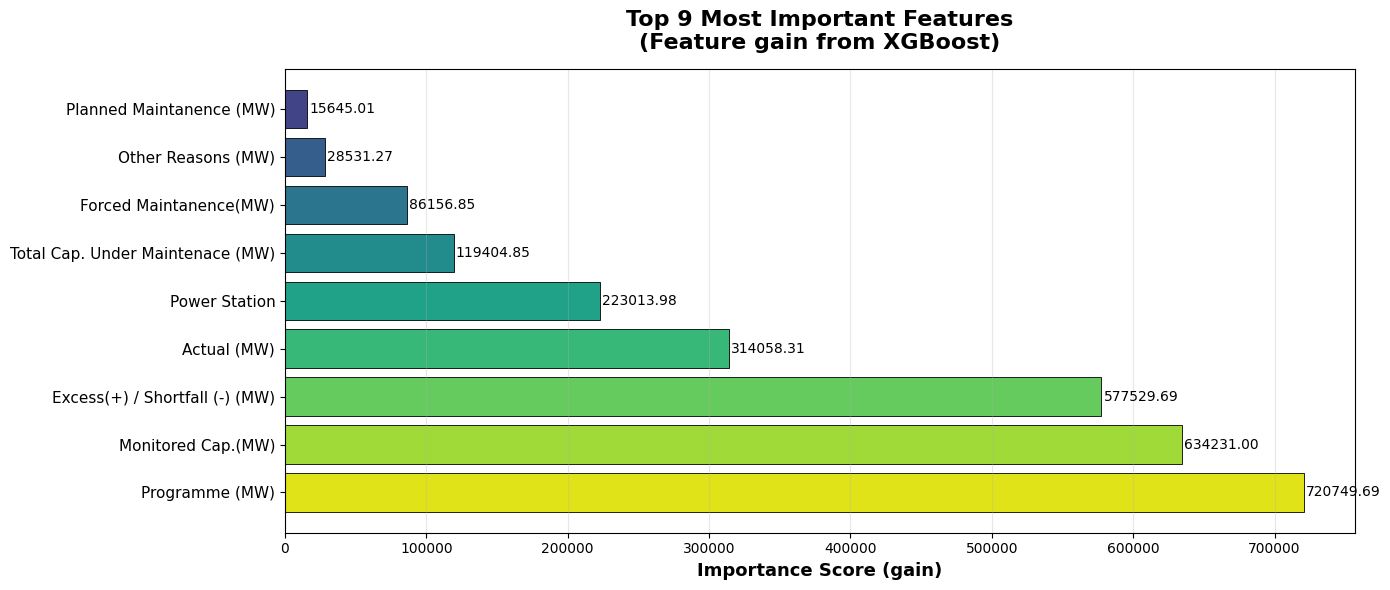

Saved feature importance plot to feature_importance_top.png


In [52]:
# ================================
# CELL 8: ENHANCED Feature Importance Analysis (robust)
# ================================
print("🔎 Analyzing feature importance (ENHANCED)...\n")
print("-" * 80)

import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb

# Determine the underlying booster and importance dictionary safely
importance_dict = {}
feature_names = None

# If model is sklearn wrapper (XGBRegressor/XGBClassifier), get booster and possibly feature names
try:
    # sklearn wrapper has get_booster() and get_xgb_params()
    booster = model.get_booster() if hasattr(model, "get_booster") else None
    if booster is not None:
        importance_dict = booster.get_score(importance_type="gain")
        # try to obtain feature names from training data if available
        if isinstance(X_tr, (np.ndarray, list)):
            feature_names = None
        else:
            # If X_tr is a DataFrame use its columns
            try:
                feature_names = list(X_tr.columns)
            except Exception:
                feature_names = None
    else:
        # model might already be a Booster (xgb.Booster)
        if isinstance(model, xgb.Booster):
            booster = model
            importance_dict = booster.get_score(importance_type="gain")
            try:
                feature_names = list(X_tr.columns)
            except Exception:
                feature_names = None
        else:
            # fallback: try model.feature_importances_ (sklearn-like)
            if hasattr(model, "feature_importances_"):
                fi = np.asarray(model.feature_importances_)
                # if we have DataFrame columns, use them
                try:
                    feature_names = list(X_tr.columns)
                    importance_dict = {str(col): float(v) for col, v in zip(feature_names, fi)}
                except Exception:
                    # fallback to numeric names f0..fn
                    importance_dict = {f"f{i}": float(v) for i, v in enumerate(fi)}
            else:
                importance_dict = {}
except Exception as e:
    print("⚠️ Warning while extracting importance:", e)
    importance_dict = {}

# If importance_dict is empty, warn and exit gracefully
if not importance_dict:
    print("No feature importances found for this model (importance_dict is empty).")
    print("If you trained using xgb.train(), ensure evals_result or booster was saved, or use model.feature_importances_.")
else:
    # importance_dict keys might be 'f0','f1' etc. Convert numeric keys to real column names if possible
    keys = list(importance_dict.keys())

    # Try map 'f0' -> column name using feature_names from X_tr (if available)
    mapped = []
    for k in keys:
        if k.startswith("f") and k[1:].isdigit() and feature_names:
            idx = int(k[1:])
            mapped_name = feature_names[idx] if idx < len(feature_names) else k
            mapped.append((mapped_name, float(importance_dict[k])))
        else:
            # keep the original key if it's already a column name
            mapped.append((k, float(importance_dict[k])))

    # Sort by importance (gain) descending
    mapped_sorted = sorted(mapped, key=lambda x: x[1], reverse=True)

    # Take top N (change if you want more)
    top_n = 30
    top = mapped_sorted[:top_n]
    features_list = [t[0] for t in top][::-1]      # reverse for horizontal bar chart (largest at top)
    importance_values = [t[1] for t in top][::-1]

    # Plot large horizontal bar chart
    fig, ax = plt.subplots(figsize=(14, max(6, len(features_list)*0.35)))

    # Color gradient
    try:
        colors = plt.cm.viridis(np.linspace(0.2, 0.95, len(features_list)))
    except Exception:
        colors = None

    y_pos = np.arange(len(features_list))
    bars = ax.barh(y_pos, importance_values, color=colors, edgecolor='black', linewidth=0.6)

    ax.set_yticks(y_pos)
    ax.set_yticklabels(features_list, fontsize=11)
    ax.invert_yaxis()  # largest on top
    ax.set_xlabel("Importance Score (gain)", fontsize=13, fontweight='bold')
    ax.set_title(f"Top {len(features_list)} Most Important Features\n(Feature gain from XGBoost)", fontsize=16, fontweight='bold', pad=14)
    ax.grid(axis='x', alpha=0.3)

    # Label bars with their values
    for i, b in enumerate(bars):
        val = importance_values[i]
        ax.text(b.get_width() + max(importance_values) * 0.002, b.get_y() + b.get_height()/2,
                f"{val:.2f}", va='center', fontsize=10)

    plt.tight_layout()
    out_file = "feature_importance_top.png"
    plt.savefig(out_file, dpi=250, bbox_inches='tight')
    plt.show()
    print(f"Saved feature importance plot to {out_file}")


In [53]:
# ====== DIAGNOSTIC + FIX: convert test DataFrame columns to numeric-friendly ======
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder

# Replace X_test below if your test variable name differs
# (if you already made X_test earlier it will use that)
try:
    X_test  # see if exists
except NameError:
    # try common alternatives
    if "test_df" in globals():
        X_test = globals()["test_df"].copy().reset_index(drop=True)
        # remove id/target if present
        for c in ["id", "ID", "Id", "target", "Deviation (MW)"]:
            if c in X_test.columns:
                X_test.drop(columns=[c], inplace=True, errors="ignore")
        print("Using test_df as X_test (id/target columns dropped if present).")
    else:
        raise NameError("X_test not found and test_df not found. Create X_test or test_df first.")

print("Initial dtypes (object/string columns):")
obj_cols = X_test.select_dtypes(include=['object','string']).columns.tolist()
for c in obj_cols:
    sample = X_test[c].dropna().astype(str).head(6).tolist()
    print(f" - {c:30s}  unique={X_test[c].nunique(dropna=True):4d}  sample={sample[:3]}")

nrows = len(X_test)
print(f"\nRows: {nrows}, object cols found: {len(obj_cols)}\n")

# Function to try parse column as date, numeric, label-encode or drop
dropped_cols = []
encoded_cols = []
coerced_numeric = []
parsed_dates = []

for col in obj_cols:
    series = X_test[col].astype(str).replace({"nan": ""}).replace({"None": ""})
    # 1) Try parse as datetime
    # try parsing a sample quickly to estimate
    sample = series.dropna().head(50).astype(str).tolist()
    parsed_count = 0
    for s in sample:
        try:
            pd.to_datetime(s, dayfirst=True, errors='raise', infer_datetime_format=True)
            parsed_count += 1
        except Exception:
            pass
    if parsed_count >= max(1, len(sample)//2):
        # treat as datetime
        try:
            X_test[col] = pd.to_datetime(X_test[col], dayfirst=True, errors='coerce')
            # convert to epoch seconds (int) for numeric models
            X_test[col] = X_test[col].view('int64') // 10**9
            parsed_dates.append(col)
            print(f"Parsed column '{col}' as datetime -> epoch seconds.")
            continue
        except Exception as e:
            print(f"Date parse attempt failed for {col}: {e}")

    # 2) Try coerce to numeric (if many values parse)
    coerced = pd.to_numeric(X_test[col].replace("", np.nan), errors="coerce")
    non_na = coerced.notna().sum()
    if non_na >= max(1, int(0.2 * nrows)):   # at least 20% numeric-like
        X_test[col] = coerced
        coerced_numeric.append((col, non_na))
        print(f"Coerced column '{col}' to numeric (kept {non_na}/{nrows} values).")
        continue

    # 3) Small-cardinality strings -> label encode
    nunique = X_test[col].nunique(dropna=True)
    if nunique <= 50:
        le = LabelEncoder()
        X_test[col] = X_test[col].fillna("___nan___").astype(str)
        try:
            X_test[col] = le.fit_transform(X_test[col])
            encoded_cols.append(col)
            print(f"Label-encoded column '{col}' (nunique={nunique}).")
            continue
        except Exception as e:
            print(f"Label encoding failed for {col}: {e}. Will drop it.")
            X_test.drop(columns=[col], inplace=True)
            dropped_cols.append(col)
            continue

    # 4) High-cardinality -> drop (safe fallback)
    X_test.drop(columns=[col], inplace=True)
    dropped_cols.append(col)
    print(f"Dropped high-cardinality text column '{col}' (nunique={nunique}).")

# Fill numeric NaNs with median
num_cols = X_test.select_dtypes(include=[np.number]).columns.tolist()
for col in num_cols:
    med = X_test[col].median()
    X_test[col] = X_test[col].fillna(med)

print("\nSummary of actions:")
print(" Parsed as dates:", parsed_dates)
print(" Coerced numeric:", [c for c,_ in coerced_numeric])
print(" Label-encoded:", encoded_cols)
print(" Dropped:", dropped_cols)

# Show remaining dtypes and head
print("\nRemaining dtypes (first 30 columns):")
print(X_test.dtypes.head(30))
print("\nPreview of converted X_test:")
display(X_test.head())

# Final check: any remaining non-numeric columns?
non_numeric_after = X_test.select_dtypes(exclude=[np.number]).columns.tolist()
if non_numeric_after:
    print("\nWARNING: Still non-numeric columns remain:")
    for c in non_numeric_after:
        print("  -", c, "unique:", X_test[c].nunique(dropna=True), "sample:", X_test[c].dropna().astype(str).head(3).tolist())
    print("\nIf these are expected, decide whether to label-encode/drop them or provide your preprocessor.")
else:
    print("\nAll columns are numeric. Ready to predict.")

# Export final array for prediction
X_arr = X_test.values
print("Final X_arr shape:", X_arr.shape)

# Save back to a global variable so later prediction cell can use it
globals()['X_test_processed_for_predict'] = X_arr
print("Saved array as variable: X_test_processed_for_predict")


Initial dtypes (object/string columns):

Rows: 50920, object cols found: 0


Summary of actions:
 Parsed as dates: []
 Coerced numeric: []
 Label-encoded: []
 Dropped: []

Remaining dtypes (first 30 columns):
Monitored Cap.(MW)                  float64
Total Cap. Under Maintenace (MW)    float64
Planned Maintanence (MW)            float64
Forced Maintanence(MW)              float64
Other Reasons (MW)                  float64
Programme (MW)                      float64
Actual (MW)                         float64
Excess(+) / Shortfall (-) (MW)      float64
Date                                float64
Power Station                       float64
dtype: object

Preview of converted X_test:


,Monitored Cap.(MW),Total Cap. Under Maintenace (MW),Planned Maintanence (MW),Forced Maintanence(MW),Other Reasons (MW),Programme (MW),Actual (MW),Excess(+) / Shortfall (-) (MW),Date,Power Station
0,0.536989,0.339914,0.938083,0.297473,-0.358275,0.845259,0.627430,-0.812179,0.0,111.0
1,-0.145922,-0.566005,-0.320684,-0.468806,-0.358275,0.100643,-0.106942,-0.810135,0.0,89.0
2,-0.603740,-0.566005,-0.320684,-0.468806,-0.358275,-0.456500,-0.512121,-0.241867,0.0,121.0
3,-0.145922,0.149194,-0.320684,0.450729,-0.358275,-0.067844,-0.158467,-0.359404,0.0,27.0
4,-0.489285,-0.208406,-0.320684,-0.009039,-0.358275,-0.534811,-0.512121,0.061687,0.0,67.0



All columns are numeric. Ready to predict.
Final X_arr shape: (50920, 10)
Saved array as variable: X_test_processed_for_predict


In [54]:
# ===== CELL 9: ALIGN test to training features, then predict (safe fallback) =====
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn.preprocessing import LabelEncoder

print("Aligning test features to training features (X_tr)...")

# 1) Check prerequisites
if "X_tr" not in globals() or not isinstance(X_tr, pd.DataFrame):
    raise NameError("X_tr (training features DataFrame) not found. Make sure X_tr is available.")

train_cols = list(X_tr.columns)
print(f"Detected {len(train_cols)} training columns. Sample: {train_cols[:10]}")

# 2) find original test DataFrame (we will use it to extract columns by name)
candidate_test_dfs = [name for name in ("test_df","test","df_test") if name in globals()]
if not candidate_test_dfs:
    raise NameError("Original test DataFrame not found (expected variable name like 'test_df'). "
                    "If you only have a processed numpy array, provide it AND the column names used in training.")
test_name = candidate_test_dfs[0]
test_df = globals()[test_name].copy().reset_index(drop=True)
print(f"Using '{test_name}' (rows={len(test_df)}) to build aligned test features.")

# 3) Build aligned DataFrame with train columns (fill missing with NaN first)
X_aligned = pd.DataFrame(index=test_df.index, columns=train_cols, dtype="float64")

# For each column expected by training, try to copy from test_df if exists; else leave NaN (will fill later)
for c in train_cols:
    if c in test_df.columns:
        X_aligned[c] = test_df[c]

# 4) Attempt smart conversions on the columns that were copied (dates/numeric/label)
for col in X_aligned.columns:
    # If dtype already numeric, skip
    if pd.api.types.is_numeric_dtype(X_aligned[col]):
        continue
    # If column not present in original test_df (all NaN), skip for now
    if X_aligned[col].isna().all():
        continue

    # Try datetime parse
    try:
        sample = X_aligned[col].dropna().astype(str).head(30).tolist()
        parsed_count = 0
        for s in sample:
            try:
                pd.to_datetime(s, dayfirst=True)
                parsed_count += 1
            except Exception:
                break
        if parsed_count >= max(1, len(sample)//2):
            X_aligned[col] = pd.to_datetime(X_aligned[col], dayfirst=True, errors="coerce")
            X_aligned[col] = X_aligned[col].astype('int64') // 10**9
            print(f"Parsed {col} as datetime -> epoch seconds")
            continue
    except Exception:
        pass

    # Try numeric coercion
    coerced = pd.to_numeric(X_aligned[col], errors="coerce")
    if coerced.notna().sum() >= max(1, int(0.2 * len(coerced))):  # >=20% numeric-like
        X_aligned[col] = coerced
        print(f"Coerced {col} to numeric (partial)")
        continue

    # Small-cardinality label-encode
    nunique = X_aligned[col].nunique(dropna=True)
    if nunique <= 50:
        try:
            le = LabelEncoder()
            X_aligned[col] = X_aligned[col].astype(str).fillna("___nan___")
            X_aligned[col] = le.fit_transform(X_aligned[col])
            print(f"Label-encoded {col} (nunique={nunique})")
            continue
        except Exception:
            pass

    # If none of the above, leave it (will be filled/dropped later)
    print(f"Left {col} as-is (will attempt to fill/drop non-numeric later)")

# 5) Ensure all columns are numeric; if object columns remain, try final coercion; if still non-numeric, fill zeros
for col in X_aligned.columns:
    if not pd.api.types.is_numeric_dtype(X_aligned[col]):
        coerced = pd.to_numeric(X_aligned[col], errors="coerce")
        X_aligned[col] = coerced

# Fill remaining NaNs with column median (or 0 if median is NaN)
for col in X_aligned.columns:
    if X_aligned[col].isna().all():
        X_aligned[col] = 0.0
    else:
        med = X_aligned[col].median()
        if pd.isna(med):
            X_aligned[col] = X_aligned[col].fillna(0.0)
        else:
            X_aligned[col] = X_aligned[col].fillna(med)

# Final check: all numeric?
non_numeric_after = X_aligned.select_dtypes(exclude=[np.number]).columns.tolist()
if non_numeric_after:
    raise ValueError("After alignment some columns are still non-numeric: " + str(non_numeric_after))

print("Aligned test DataFrame ready. Shape:", X_aligned.shape)

# 6) Convert to numpy and predict (ensuring DMatrix uses train_cols)
X_arr = X_aligned.values
print("Creating DMatrix with feature_names from training columns.")
dtest = xgb.DMatrix(X_arr, feature_names=train_cols)

# 7) Predict
if isinstance(model, xgb.Booster):
    preds = model.predict(dtest)
else:
    preds = model.predict(X_arr)

preds = np.asarray(preds).ravel()
print(f"Predicted {len(preds):,} rows. Stats min/max/mean/std: {preds.min():.4f}/{preds.max():.4f}/{preds.mean():.4f}/{preds.std():.4f}")

# 8) Save submission (preserve id if present)
id_cols = [c for c in ["id","ID","Id","case_id","sample_id"] if c in test_df.columns]
if id_cols:
    submission = pd.DataFrame({ id_cols[0]: test_df[id_cols[0]].values, "prediction": preds })
else:
    submission = pd.DataFrame({ "index": np.arange(len(preds)), "prediction": preds })

submission.to_csv("submission.csv", index=False)
print("Saved submission.csv (first rows):")
display(submission.head())

# Expose for downstream cells
test_preds = preds
X_test_aligned = X_aligned


Aligning test features to training features (X_tr)...
Detected 10 training columns. Sample: ['Monitored Cap.(MW)', 'Total Cap. Under Maintenace (MW)', 'Planned Maintanence (MW)', 'Forced Maintanence(MW)', 'Other Reasons (MW)', 'Programme (MW)', 'Actual (MW)', 'Excess(+) / Shortfall (-) (MW)', 'Date', 'Power Station']
Using 'test_df' (rows=50920) to build aligned test features.
Parsed Date as datetime -> epoch seconds
Left Power Station as-is (will attempt to fill/drop non-numeric later)
Aligned test DataFrame ready. Shape: (50920, 10)
Creating DMatrix with feature_names from training columns.
Predicted 50,920 rows. Stats min/max/mean/std: -69.7643/199.7763/-3.8098/25.5829
Saved submission.csv (first rows):


,index,prediction
0,0,-26.176455
1,1,-23.575663
2,2,-55.609787
3,3,-19.211952
4,4,-6.691413


,index,prediction
0,0,-26.176455
1,1,-23.575663
2,2,-55.609787
3,3,-19.211952
4,4,-6.691413


rows: 50920
stats:               count      mean        std       min        25%      50%  \
prediction  50920.0 -3.809823  25.583181 -69.76434 -13.308094 -3.53605   

                 75%        max  
prediction  6.120346  199.77628  


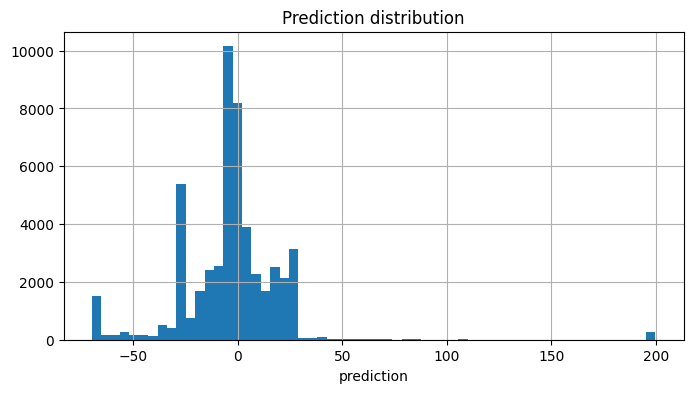

In [55]:
import pandas as pd
import matplotlib.pyplot as plt

sub = pd.read_csv("submission.csv")
display(sub.head())
print("rows:", len(sub))
print("stats:", sub['prediction'].describe().to_frame().T)

# Quick histogram
plt.figure(figsize=(8,4))
sub['prediction'].hist(bins=60)
plt.title("Prediction distribution")
plt.xlabel("prediction")
plt.show()


In [58]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
import xgboost as xgb

# Convert validation features to DMatrix
dval = xgb.DMatrix(X_val)

# Predict
val_preds = model.predict(dval)

# Metrics
mae = mean_absolute_error(y_val, val_preds)
rmse = np.sqrt(mean_squared_error(y_val, val_preds))
r2 = r2_score(y_val, val_preds)

# MAPE
mape = np.mean(np.abs((y_val - val_preds) / (y_val + 1e-8))) * 100
accuracy = 100 - mape

print("📊 MODEL PERFORMANCE (Validation Set)")
print(f"MAE       : {mae:.4f}")
print(f"RMSE      : {rmse:.4f}")
print(f"R²        : {r2:.4f}  (Accuracy ≈ {r2*100:.2f}%)")
print(f"MAPE      : {mape:.2f}%")
print(f"Accuracy  : {accuracy:.2f}% (100 - MAPE)\n")


📊 MODEL PERFORMANCE (Validation Set)
MAE       : 1.3020
RMSE      : 16.0705
R²        : 0.9497  (Accuracy ≈ 94.97%)
MAPE      : 2224273181.12%
Accuracy  : -2224273081.12% (100 - MAPE)

